In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.io import loadmat
from scipy.stats import multivariate_normal

np.random.seed(42)

# Q2
## Implementing EM for MNIST dataset, with PCA for dimensionality reduction.

Implement the EM algorithm for fitting a Gaussian mixture model for the MNIST dataset.
We reduce the dataset to be only two cases, of digits “2” and “6” only. Thus, you will fit
GMM with C = 2. Use the data file data.mat or data.dat. True label of the data are also
provided in label.mat and label.dat
The matrix images is of size 784-by-1990, i.e., there are totally 1990 images, and each
column of the matrix corresponds to one image of size 28-by-28 pixels (the image is vectorized;
the original image can be recovered by map the vector into a matrix).
First use PCA to reduce the dimensionality of the data before applying to EM. We will
put all “6” and “2” digits together, to project the original data into 5-dimensional vectors.
Now implement EM algorithm for the projected data (with 5-dimensions).

#### 1. Select from data one raw image of “2” and “6” and visualize them, respectively.

In [2]:
data = loadmat('data.mat')['data'].T
labels = loadmat('label.mat')['trueLabel']

In [3]:
two = data[0, :]
six = data[-1, :]

orig_shape = (28,28)

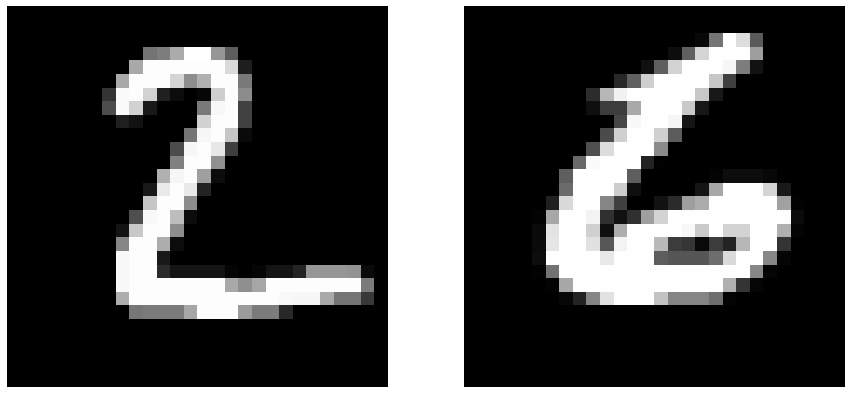

In [4]:
plt.subplots(nrows=1, ncols=2, figsize=(15,8))
plt.subplot(121)
plt.imshow(two.reshape(orig_shape).T, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(six.reshape(orig_shape).T, cmap='gray')
plt.axis('off')
plt.show()

#### Write down detailed expression of the E-step and M-step in the EM algorithm (hint: when computing τ k i , you can drop the (2π) n/2 factor from the numerator and denominator expression, since it will be canceled out; this can help avoid some numerical issues in computation).

#### 3. Implement EM algorithm yourself. Use the following initialization
* initialization for mean: random Gaussian vector with zero mean
* initialization for covariance: generate two Gaussian random matrix of size n-by- n: $S_1$ and $S_2$ , and initialize the covariance matrix for the two components are $\Sigma_1 = S_1S_1^T + I_n$ , and $\Sigma_2 = S_2S_2^T + I_n$ , where $I_n$ is an identity matrix of size n-by-n.

In [5]:
class GMM:
    def __init__(self, K: int, maxIter: int, tol=1e-3) -> None:
        
        #Number of gaussian clusters
        self.K = K
        self.maxIter = maxIter
        self.tol = tol
        
    def fit(self, X: np.array):
        
        assert len(X.shape) >= 2, 'If passing a vector of data, ensure two dimensions by reshaping data "X.reshape(-1,1)"'
        #initialize clusters
        self._initialize(X=X)
        
        for i in range(self.maxIter):
            
            print('.........iteration {}.........'.format(i))
            #run the E step
            self._expectation(X)
            
            #run the M step
            self._maximization(X)
            
            diff = np.linalg.norm(self.mus - self.mus_old)

            if np.linalg.norm(self.mus-self.mus_old) < self.tol:
                print('Converged!')
                break
            
            self.mus_old = self.mus.copy()
        
        if i == self.maxIter-1:
            print('Max iterations reached')
    
    def _initialize(self, X):
        #get shape of the data
        m,n = X.shape
        
        #initialize K-gaussian clusters with mean randomly sampled from 0 centered Gaussian
        self.mus = np.random.randn(self.K, n)
        self.mus_old = self.mus.copy()
        
        #initialize K-covariance matrices
        self.covs = []
        for _ in range(self.K):
            S = np.random.randn(n,n)
            S = S@S.T + np.eye(n)
            self.covs.append(S)

        
        #initialize priors
        self.pis = np.random.random(self.K)
        self.pis = self.pis / np.sum(self.pis)
        
        #initialize the posterior
        self.tau = np.full((m,self.K), fill_value=0.)
        
    def _expectation(self, X: np.array):
        
        for i in range(self.K):
            self.tau[:, i] = self.pis[i] * multivariate_normal.pdf(X, 
                                                                   self.mus[i], 
                                                                   self.covs[i])
        #normalize tau
        sum_tau = np.sum(self.tau, axis=1).reshape(-1,1)
        self.tau = np.divide(self.tau, np.tile(sum_tau, (1,self.K)))
        
    def _maximization(self, X: np.array):
        
        m,n = X.shape
        
        for i in range(self.K):
            
            #update priors
            self.pis[i] = np.sum(self.tau[:,i]) / m
            
            #update cluster mean
            self.mus[i] = X.T @ self.tau[:, i] / np.sum(self.tau[:,i], axis=0)
            
            #update cluster covariance
            dummy = X - np.tile(self.mus[i], (m,1))
            self.covs[i] = dummy.T @ np.diag(self.tau[:, i]) @ dummy / np.sum(self.tau[:,i], axis=0)

In [ ]:
test = GMM(3, 100)

In [ ]:
test.fit(pdata)

In [6]:
data.shape

(1990, 784)